In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import math
from sklearn.metrics import r2_score
import time
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

In [ ]:

# ──────────────────────────────────────────────────────────────────────────────
# 1) 데이터셋 로드 & 분할
# ──────────────────────────────────────────────────────────────────────────────
raw = torch.load('/content/drive/MyDrive/DEAM_dataset_cleaned.pt')

# dict with keys 'spectrograms', 'annotations', 'song_ids'
clean_specs = raw['spectrograms']   # Tensor list or Tensor of shape (N,1,128,60)
clean_anns  = raw['annotations']    # Tensor list or Tensor of shape (N,60,2)
clean_ids   = raw['song_ids']       # list or Tensor of shape (N,)

# make sure they're all the same length N
N = len(clean_ids)

# build unified list of dicts
data_list = []
for i in range(N):
    song_id = int(clean_ids[i])

    spec    = clean_specs[i]   # Tensor[1,128,60]
    ann     = clean_anns[i]    # Tensor[60,2]
    data_list.append({'song_id': song_id, 'spec': spec, 'ann': ann})


In [ ]:

# ──────────────────────────────────────────────────────────────────────────────
# 2) Train/Val/Test 데이터 분할 (정규화 포함)
# ──────────────────────────────────────────────────────────────────────────────

# Step 1: song_id를 기준으로 데이터 아이템을 train/val과 test용으로 먼저 분리합니다.
train_val_ids = {d['song_id'] for d in data_list if d['song_id'] <= 2000}
test_ids      = {d['song_id'] for d in data_list if d['song_id']  > 2000}

train_val_items = [d for d in data_list if d['song_id'] in train_val_ids]
test_items      = [d for d in data_list if d['song_id'] in test_ids]

# Step 2: train_val_items를 train과 validation용으로 다시 분할합니다.
#         random_split을 사용하기 위해 임시 Dataset을 만듭니다.
class TempDataset(Dataset):
    def __init__(self, items): self.items = items
    def __len__(self): return len(self.items)
    def __getitem__(self, idx): return self.items[idx]

val_ratio = 0.1
temp_ds = TempDataset(train_val_items)
val_size = int(len(temp_ds) * val_ratio)
train_size = len(temp_ds) - val_size

train_subset, val_subset = random_split(
    temp_ds, [train_size, val_size], generator=torch.Generator().manual_seed(42)
)

# 분할된 subset에서 실제 데이터 아이템 리스트를 다시 추출합니다.
train_items = [item for item in train_subset]
val_items   = [item for item in val_subset]


# Step 3: ★★★ 오직 Train 데이터셋의 스펙트로그램으로만 평균과 표준편차를 계산합니다. ★★★
print("학습 데이터셋에서 정규화 통계치 계산 중...")
train_specs = torch.cat([d['spec'] for d in train_items], dim=0) # 모든 스펙트로그램을 배치 차원으로 연결
mean = train_specs.mean()
std = train_specs.std()

print(f"  - 계산된 Mean: {mean:.4f}")
print(f"  - 계산된 Std Dev: {std:.4f}")
# 이 값을 저장해두면 나중에 추론 시에도 사용할 수 있습니다.
torch.save({'mean': mean, 'std': std}, 'norm_stats.pt')


# Step 4: 계산된 통계치(mean, std)를 모든 데이터에 적용합니다.
#         (메모리 절약을 위해 in-place로 연산)
def normalize_items(items, mean, std):
    for item in items:
        item['spec'] = (item['spec'] - mean) / (std + 1e-8) # 0으로 나누는 것을 방지
    return items

train_items = normalize_items(train_items, mean, std)
val_items   = normalize_items(val_items, mean, std)
test_items  = normalize_items(test_items, mean, std)
print("모든 데이터셋(Train/Val/Test)에 정규화를 적용했습니다.")


# Step 5: 최종 PyTorch Dataset을 생성합니다.
class DEAMDataset(Dataset):
    def __init__(self, items):
        self.samples = items
    def __len__(self):
        return len(self.samples)
    def __getitem__(self, idx):
        # 데이터가 이미 정규화되었으므로 그대로 반환
        return self.samples[idx]['spec'], self.samples[idx]['ann']

train_ds = DEAMDataset(train_items)
val_ds   = DEAMDataset(val_items)
test_ds  = DEAMDataset(test_items)

print(f"\n데이터셋 준비 완료:")
print(f"  - Train: {len(train_ds)} 샘플")
print(f"  - Validation: {len(val_ds)} 샘플")
print(f"  - Test: {len(test_ds)} 샘플")


학습 데이터셋에서 정규화 통계치 계산 중...
  - 계산된 Mean: -47.9824
  - 계산된 Std Dev: 19.8544
모든 데이터셋(Train/Val/Test)에 정규화를 적용했습니다.

데이터셋 준비 완료:
  - Train: 1570 샘플
  - Validation: 174 샘플
  - Test: 58 샘플


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 3) DataLoader
# ──────────────────────────────────────────────────────────────────────────────
batch_size  = 16
num_workers = 2

train_loader = DataLoader(train_ds,   batch_size=batch_size, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_ds,     batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader  = DataLoader(test_ds,    batch_size=batch_size, shuffle=False, num_workers=num_workers)


In [ ]:
def safe_collate(batch):
    # batch: list of (spec,ann)
    specs, anns = zip(*batch)
    # 각 원소를 반드시 clone() 하여 독립 스토리지 확보
    specs = [torch.as_tensor(s, dtype=torch.float32).clone() for s in specs]
    anns  = [torch.as_tensor(a, dtype=torch.float32).clone() for a in anns]
    return torch.stack(specs, 0), torch.stack(anns, 0)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                          num_workers=4, collate_fn=safe_collate)

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 1) Concordance Correlation Coefficient 정의
# ──────────────────────────────────────────────────────────────────────────────
def concordance_correlation_coefficient(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    true_mean = np.mean(y_true)
    pred_mean = np.mean(y_pred)
    covariance = np.mean((y_true - true_mean) * (y_pred - pred_mean))
    true_var = np.var(y_true)
    pred_var = np.var(y_pred)
    return 2 * covariance / (true_var + pred_var + (true_mean - pred_mean)**2 + 1e-8)

## MK1

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) 모델 정의 (CNN + Transformer)
# ──────────────────────────────────────────────────────────────────────────────
class DetailedEmotionCNN(nn.Module):
    def __init__(self, dropout_cfg=(0.3,0.3,0.4,0.4), negative_slope=0.8):
        super().__init__()
        d1,d2,d3,d4 = dropout_cfg
        nl = negative_slope

        # Block1
        self.block1 = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), nn.BatchNorm2d(16),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(16,16,3,padding=1), nn.BatchNorm2d(16),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d1),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block2
        self.block2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1), nn.BatchNorm2d(32),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d2),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block3
        self.block3 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d3),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block4 + extra conv+pool
        self.block4 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d4),
            nn.MaxPool2d((2,1),stride=(2,1)),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.MaxPool2d((8,1),stride=(8,1)),
        )
        # 마지막 채널 2개로
        self.conv_out = nn.Conv2d(128,2,1)

    def forward(self, x):
        # x: [B,1,128,60]
        x = self.block1(x)   # → [B,16,64,60]
        x = self.block2(x)   # → [B,32,32,60]
        x = self.block3(x)   # → [B,64,16,60]
        x = self.block4(x)   # → [B,128,1,60]
        x = self.conv_out(x) # → [B,2,1,60]
        x = x.squeeze(2)     # → [B,2,60]
        return x.permute(0,2,1)  # → [B,60,2]  (valence/arousal)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x: [B,T,d_model]
        return x + self.pe[:,:x.size(1),:]


class CNNTransformerEmotion(nn.Module):
    def __init__(self,
                 cnn: nn.Module,
                 d_model: int = 128,
                 nhead: int = 8,
                 num_layers: int = 4,
                 dim_feedforward: int = 512,
                 dropout: float = 0.2,
                 seq_len: int = 60):
        super().__init__()
        self.cnn = cnn
        # CNN에서 2채널 → d_model로 매핑
        self.channel_mapper = nn.Conv2d(2, d_model, 1)
        self.pos_encoder   = PositionalEncoding(d_model, max_len=seq_len)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, activation='relu'
        )
        self.transformer = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.regressor   = nn.Linear(d_model, 2)

    def forward(self, x):
        # x: [B,1,128,60]
        feat = self.cnn(x)          # → [B,60,2]
        feat = feat.permute(0,2,1).unsqueeze(-1)   # → [B,2,60,1]
        feat = self.channel_mapper(feat)           # → [B,d_model,60,1]
        seq  = feat.squeeze(-1).permute(0,2,1)     # → [B,60,d_model]
        seq  = self.pos_encoder(seq)               # → [B,60,d_model]
        seq  = self.transformer(seq)               # → [B,60,d_model]
        return torch.tanh(self.regressor(seq))     # → [B,60,2]

##Model MK2

CNN Output (128,2,1) >> (B,60,128)

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) 모델 정의 (CNN + Transformer) - 수정된 버전
# ──────────────────────────────────────────────────────────────────────────────

class FeatureExtractorCNN(nn.Module):
    """
    [수정] CNN의 역할을 정보 압축이 아닌 '풍부한 특징 추출'로 변경합니다.
    - 최종 출력은 (B, 60, 128) 모양의 특징 시퀀스가 됩니다.
    """
    def __init__(self, dropout_cfg=(0.3,0.3,0.4,0.4), negative_slope=0.02):
        super().__init__()
        d1,d2,d3,d4 = dropout_cfg
        nl = negative_slope

        # Block1: (B, 1, 128, 60) -> (B, 16, 64, 60)
        self.block1 = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), nn.BatchNorm2d(16),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(16,16,3,padding=1), nn.BatchNorm2d(16),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d1),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block2: (B, 16, 64, 60) -> (B, 32, 32, 60)
        self.block2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1), nn.BatchNorm2d(32),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d2),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block3: (B, 32, 32, 60) -> (B, 64, 16, 60)
        self.block3 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d3),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block4: (B, 64, 16, 60) -> (B, 128, 1, 60)
        self.block4 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d4),
            nn.MaxPool2d((2,1),stride=(2,1)),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.MaxPool2d((8,1),stride=(8,1)),
        )
        # [삭제] 정보를 압축하던 마지막 Conv2d 레이어를 제거합니다.
        # self.conv_out = nn.Conv2d(128,2,1)

    def forward(self, x):
        # x: [B, 1, 128, 60]
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)   # → [B, 128, 1, 60]

        # [수정] Transformer가 입력받기 좋은 형태로 모양을 변경합니다.
        # [B, 128, 1, 60] -> [B, 128, 60] -> [B, 60, 128]
        x = x.squeeze(2)
        return x.permute(0,2,1)


class PositionalEncoding(nn.Module): # (이전과 동일)
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:,:x.size(1),:]


class EmotionModel(nn.Module):
    """
    [수정] CNN과 Transformer를 올바르게 결합한 새로운 모델 클래스입니다.
    """
    def __init__(self,
                 cnn: nn.Module,
                 d_model: int = 128,  # CNN의 출력 차원과 동일해야 함
                 nhead: int = 8,
                 num_layers: int = 4,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1,
                 seq_len: int = 60):
        super().__init__()
        self.cnn = cnn
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, activation='relu',
            batch_first=True  # [수정] batch_first=True로 설정하여 (B, T, D) 입력을 처리
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 2) # 최종 출력은 2 (Valence, Arousal)

    def forward(self, x):
        # x: [B, 1, 128, 60]
        feat = self.cnn(x)          # → [B, 60, 128] (풍부한 특징 시퀀스)
        seq  = self.pos_encoder(feat) # → [B, 60, 128]
        seq  = self.transformer(seq)  # → [B, 60, 128] (시간적 패턴 학습)

        # 최종적으로 각 시간 스텝별로 Valence, Arousal 예측
        return torch.tanh(self.regressor(seq)) # → [B, 60, 2]

# 모델 인스턴스 생성 (새로운 클래스 이름으로)
base_cnn = FeatureExtractorCNN()
model = EmotionModel(base_cnn).to(device)

# 이후 Optimizer, Scheduler, Loss, 학습 루프는 그대로 사용하시면 됩니다.

 ##CCC*

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# [추가] CCC Loss 함수 정의
# ──────────────────────────────────────────────────────────────────────────────
class CCCLoss(nn.Module):
    def __init__(self):
        super(CCCLoss, self).__init__()

    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        """
        Concordance Correlation Coefficient (CCC) Loss.
        - y_pred: 예측값, shape = [B, T, 2]
        - y_true: 실제값, shape = [B, T, 2]
        """
        # Valence와 Arousal을 분리
        y_true_v = y_true[..., 0]
        y_pred_v = y_pred[..., 0]
        y_true_a = y_true[..., 1]
        y_pred_a = y_pred[..., 1]

        # 각 차원에 대해 CCC 계산
        ccc_v = self._ccc_metric(y_pred_v, y_true_v)
        ccc_a = self._ccc_metric(y_pred_a, y_true_a)

        # CCC는 클수록 좋으므로, (1 - CCC)를 손실로 사용 (작을수록 좋게 만듬)
        # 두 차원의 손실을 평균내어 반환
        return ( (1 - ccc_v) + (1 - ccc_a) ) / 2

    def _ccc_metric(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        # 텐서를 1차원으로 펼침
        y_true_flat = y_true.view(-1)
        y_pred_flat = y_pred.view(-1)

        # 평균 계산
        mean_true = torch.mean(y_true_flat)
        mean_pred = torch.mean(y_pred_flat)

        # 분산 계산
        var_true = torch.var(y_true_flat)
        var_pred = torch.var(y_pred_flat)

        # 공분산 계산
        covariance = torch.mean((y_true_flat - mean_true) * (y_pred_flat - mean_pred))

        # 분모가 0이 되는 것을 방지하기 위한 작은 값 (epsilon)
        epsilon = 1e-8

        # CCC 공식 적용
        ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred)**2 + epsilon)

        return ccc

## 기존 Device ~ Instance

In [ ]:

# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# MK1 모델 인스턴스
base_cnn = DetailedEmotionCNN()
model    = CNNTransformerEmotion(base_cnn).to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable   = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total: {total_params:,}개, Trainable: {trainable:,}개")


# ──────────────────────────────────────────────────────────────────────────────
# 5) Optimizer / Scheduler / Loss 설정
# ──────────────────────────────────────────────────────────────────────────────
lr, weight_decay = 1e-4, 1e-7
optimizer   = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler   = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
criterion   = nn.MSELoss()
#criterion   = CCCLoss()

early_stop_patience = 10
model

Total: 1,236,020개, Trainable: 1,236,020개


CNNTransformerEmotion(
  (cnn): DetailedEmotionCNN(
    (block1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.8, inplace=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.8, inplace=True)
      (6): Dropout(p=0.3, inplace=False)
      (7): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
    )
    (block2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.8, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4

## 기존 학습

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) TRAIN / VAL / TEST 루프
# ──────────────────────────────────────────────────────────────────────────────
best_val_loss      = float('inf')
early_stop_counter = 0

for epoch in range(1, 71):
    # -- TRAIN --
    model.train()
    train_loss = 0.0
    for spec, ann in train_loader:
        spec, ann = spec.to(device), ann.to(device)
        optimizer.zero_grad()
        out = model(spec)        # [B,60,2]
        loss = criterion(out, ann)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * spec.size(0)
    train_loss /= len(train_loader.dataset)

    # -- VALIDATION --
    model.eval()
    val_loss = 0.0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for spec, ann in val_loader:
            spec, ann = spec.to(device), ann.to(device)
            out = model(spec)
            val_loss += criterion(out, ann).item() * spec.size(0)
            all_preds.append(out.cpu().numpy().reshape(-1,2))
            all_trues.append(ann.cpu().numpy().reshape(-1,2))
    val_loss /= len(val_loader.dataset)

    preds = np.vstack(all_preds)
    trues = np.vstack(all_trues)
    # 지표 계산
    mse     = np.mean((preds-trues)**2)
    mae     = np.mean(np.abs(preds-trues))
    r_val   = np.corrcoef(trues[:,0],preds[:,0])[0,1]
    r_aro   = np.corrcoef(trues[:,1],preds[:,1])[0,1]
    r2_val  = r2_score(trues[:,0],preds[:,0])
    r2_aro  = r2_score(trues[:,1],preds[:,1])
    ccc_val = concordance_correlation_coefficient(trues[:,0],preds[:,0])
    ccc_aro = concordance_correlation_coefficient(trues[:,1],preds[:,1])

    # Scheduler & EarlyStopping
    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss, best_epoch = val_loss, epoch
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        early_stop_counter += 1

    lr_current = optimizer.param_groups[0]['lr']
    print(f"[{epoch:02d}] Train:{train_loss:.4f} | Val:{val_loss:.4f} | LR:{lr_current:.2e}")
    print(f"    MSE:{mse:.4f}, MAE:{mae:.4f}, Corr(V/A):{r_val:.4f}/{r_aro:.4f}, "
          f"R2(V/A):{r2_val:.4f}/{r2_aro:.4f}, CCC(V/A):{ccc_val:.4f}/{ccc_aro:.4f}")

    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping @ epoch {epoch} (Best Val {best_val_loss:.4f} @ {best_epoch})")
        break

print(f"\n== Training completed. Best Val Loss: {best_val_loss:.4f} @ epoch {best_epoch} ==")



[01] Train:0.0864 | Val:0.0479 | LR:1.00e-04
    MSE:0.0479, MAE:0.1732, Corr(V/A):0.3624/0.7097, R2(V/A):0.0973/0.4996, CCC(V/A):0.2896/0.6576
[02] Train:0.0610 | Val:0.0449 | LR:1.00e-04
    MSE:0.0449, MAE:0.1675, Corr(V/A):0.3938/0.7363, R2(V/A):0.1526/0.5318, CCC(V/A):0.2915/0.6703
[03] Train:0.0541 | Val:0.0440 | LR:1.00e-04
    MSE:0.0440, MAE:0.1640, Corr(V/A):0.4130/0.7749, R2(V/A):0.1680/0.5417, CCC(V/A):0.2743/0.6720
[04] Train:0.0525 | Val:0.0432 | LR:1.00e-04
    MSE:0.0432, MAE:0.1613, Corr(V/A):0.4222/0.7745, R2(V/A):0.1576/0.5686, CCC(V/A):0.2978/0.6959
[05] Train:0.0501 | Val:0.0428 | LR:1.00e-04
    MSE:0.0428, MAE:0.1660, Corr(V/A):0.4539/0.7645, R2(V/A):0.2040/0.5436, CCC(V/A):0.3191/0.6884
[06] Train:0.0488 | Val:0.0446 | LR:1.00e-04
    MSE:0.0446, MAE:0.1696, Corr(V/A):0.4446/0.7662, R2(V/A):0.1811/0.5182, CCC(V/A):0.2707/0.6688
[07] Train:0.0473 | Val:0.0428 | LR:1.00e-04
    MSE:0.0428, MAE:0.1655, Corr(V/A):0.4538/0.7862, R2(V/A):0.2056/0.5426, CCC(V/A):0.3447

## Test

곡 단위 테스트 데이터 예측을 시작합니다...

== 전체 Test Set 결과 ==
  MSE: 0.0831, MAE: 0.2268
  R2 (V/A): -0.3627 / 0.2660
  CCC (V/A): -0.0400 / 0.4384


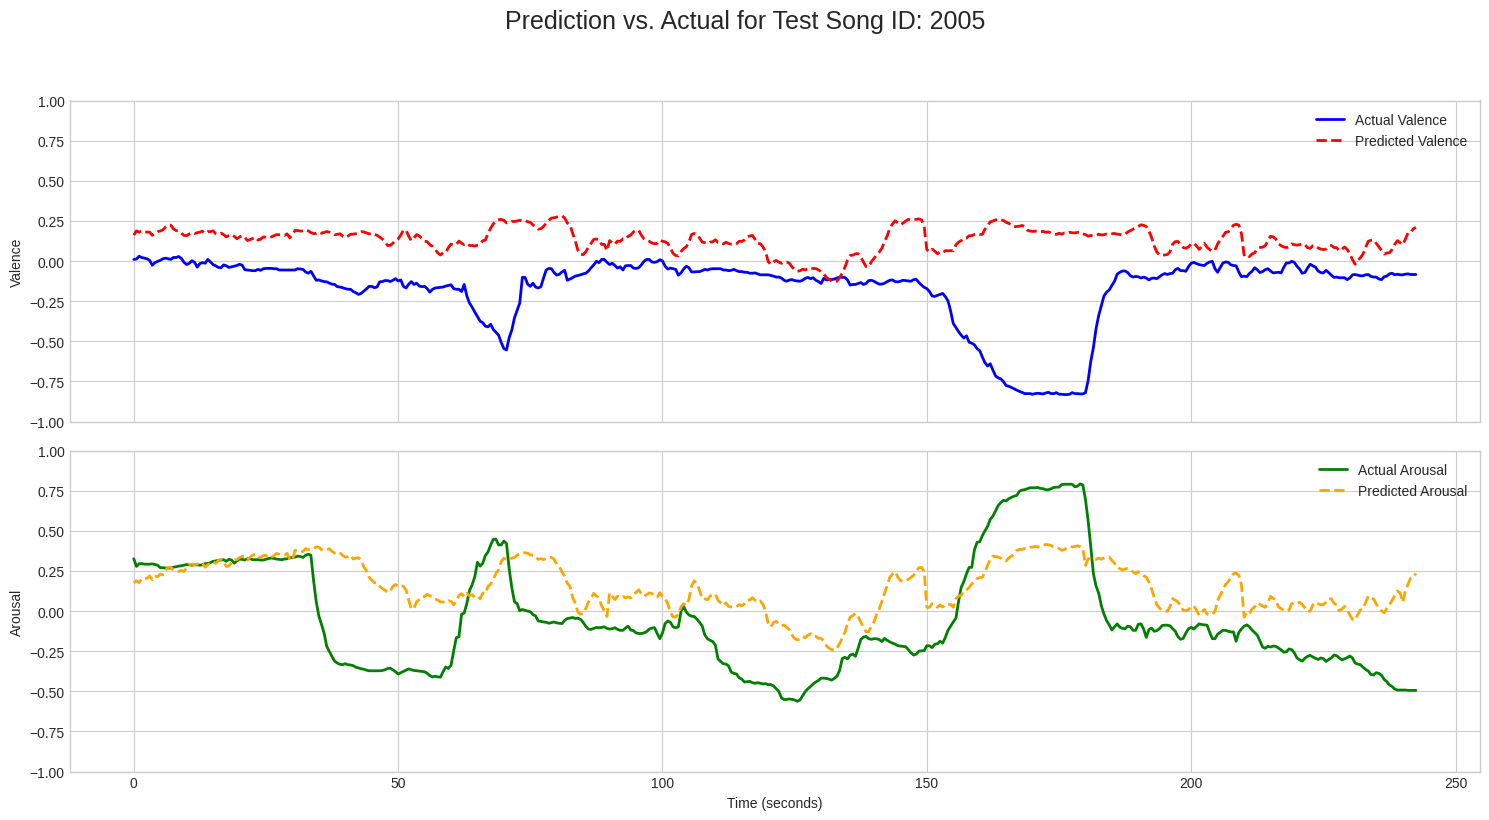


시각화 그래프를 'song_prediction_visualization.png' 파일로 저장했습니다.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import r2_score

def concordance_correlation_coefficient(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    true_mean = np.mean(y_true)
    pred_mean = np.mean(y_pred)
    covariance = np.mean((y_true - true_mean) * (y_pred - pred_mean))
    true_var = np.var(y_true)
    pred_var = np.var(y_pred)
    return 2 * covariance / (true_var + pred_var + (true_mean - pred_mean)**2 + 1e-8)


# ──────────────────────────────────────────────────────────────────────────────
# 1) 모델 로드 및 평가 준비
# ──────────────────────────────────────────────────────────────────────────────
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_song_preds = []
all_song_trues = []

print("곡 단위 테스트 데이터 예측을 시작합니다...")

# ──────────────────────────────────────────────────────────────────────────────
# 2) DataLoader 대신 test_items 리스트를 직접 순회하며 곡 단위로 예측
# ──────────────────────────────────────────────────────────────────────────────
for song_data in test_items:
    # spec_tensor의 모양: [1, 128, T_variable] (채널 차원 유지)
    spec_tensor = song_data['spec']
    ann_tensor = song_data['ann']

    T = spec_tensor.shape[-1]
    windows = []
    for start in range(0, T, 60):
        # win의 모양: [1, 128, 60] (채널 차원 유지)
        win = spec_tensor[:, :, start:start+60]

        if win.size(-1) < 60:
            pad_size = 60 - win.size(-1)
            win = torch.nn.functional.pad(win, (0, pad_size), "constant", 0)

        windows.append(win)

    if not windows:
        continue

    # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
    # [최종 수정] torch.cat 대신 torch.stack을 사용하여 올바른 4D 배치 생성
    # [1, 128, 60] 모양의 윈도우 리스트 -> [num_windows, 1, 128, 60] 모양의 4D 텐서
    # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
    batch = torch.stack(windows, dim=0)

    # stack은 새로운 차원을 생성하므로, 불필요한 차원이 있다면 squeeze()로 제거
    # 현재 `win`의 shape이 [1,128,60]이므로 stack 후 [num_win, 1, 128, 60]이 됨
    # 이 모양이 모델에 정확히 맞으므로 squeeze()는 필요 없습니다.
    batch = batch.to(device)


    with torch.no_grad():
        out = model(batch)

    preds_padded = out.cpu().numpy().reshape(-1, 2)
    preds_song = preds_padded[:T]

    all_song_preds.append(preds_song)
    all_song_trues.append(ann_tensor.cpu().numpy())


# ──────────────────────────────────────────────────────────────────────────────
# 3) 전체 테스트셋에 대한 평가 지표 계산 및 출력 (이전과 동일)
# ──────────────────────────────────────────────────────────────────────────────
if all_song_preds:
    preds_flat = np.vstack(all_song_preds)
    trues_flat = np.vstack(all_song_trues)

    mse = np.mean((preds_flat - trues_flat) ** 2)
    mae = np.mean(np.abs(preds_flat - trues_flat))
    r2_val = r2_score(trues_flat[:, 0], preds_flat[:, 0])
    r2_aro = r2_score(trues_flat[:, 1], preds_flat[:, 1])
    ccc_val = concordance_correlation_coefficient(trues_flat[:, 0], preds_flat[:, 0])
    ccc_aro = concordance_correlation_coefficient(trues_flat[:, 1], preds_flat[:, 1])

    print("\n== 전체 Test Set 결과 ==")
    print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}")
    print(f"  R2 (V/A): {r2_val:.4f} / {r2_aro:.4f}")
    print(f"  CCC (V/A): {ccc_val:.4f} / {ccc_aro:.4f}")
else:
    print("예측 결과가 없습니다.")


# ──────────────────────────────────────────────────────────────────────────────
# 4) 테스트셋의 첫 번째 곡에 대한 결과 시각화 (이전과 동일)
# ──────────────────────────────────────────────────────────────────────────────

songidid = 4
if all_song_preds:
    preds_to_plot = all_song_preds[songidid]
    trues_to_plot = all_song_trues[songidid]
    time_axis = np.arange(len(preds_to_plot)) * 0.5

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    song_id_to_plot = test_items[songidid]['song_id']
    fig.suptitle(f'Prediction vs. Actual for Test Song ID: {song_id_to_plot}', fontsize=18, y=1.02)

    ax1.plot(time_axis, trues_to_plot[:, 0], label='Actual Valence', color='blue', linewidth=2)
    ax1.plot(time_axis, preds_to_plot[:, 0], label='Predicted Valence', color='red', linestyle='--', linewidth=2)
    ax1.set_ylabel('Valence')
    ax1.legend()
    ax1.set_ylim(-1, 1)

    ax2.plot(time_axis, trues_to_plot[:, 1], label='Actual Arousal', color='green', linewidth=2)
    ax2.plot(time_axis, preds_to_plot[:, 1], label='Predicted Arousal', color='orange', linestyle='--', linewidth=2)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Arousal')
    ax2.legend()
    ax2.set_ylim(-1, 1)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('song_prediction_visualization.png')
    plt.show()

    print(f"\n시각화 그래프를 'song_prediction_visualization.png' 파일로 저장했습니다.")

## MK4

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) 모델 정의 (CNN + Transformer) - 수정된 버전
# ──────────────────────────────────────────────────────────────────────────────

class FeatureExtractorCNN(nn.Module):
    """
    [수정] CNN의 역할을 정보 압축이 아닌 '풍부한 특징 추출'로 변경합니다.
    - 최종 출력은 (B, 60, 128) 모양의 특징 시퀀스가 됩니다.
    """
    def __init__(self, dropout_cfg=(0.3,0.3,0.4,0.4), negative_slope=0.8):
        super().__init__()
        d1,d2,d3,d4 = dropout_cfg
        nl = negative_slope

        # Block1: (B, 1, 128, 60) -> (B, 16, 64, 60)
        self.block1 = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1), nn.BatchNorm2d(16),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(16,16,3,padding=1), nn.BatchNorm2d(16),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d1),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block2: (B, 16, 64, 60) -> (B, 32, 32, 60)
        self.block2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1), nn.BatchNorm2d(32),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(32,32,3,padding=1), nn.BatchNorm2d(32),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d2),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block3: (B, 32, 32, 60) -> (B, 64, 16, 60)
        self.block3 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1), nn.BatchNorm2d(64),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(64,64,3,padding=1), nn.BatchNorm2d(64),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d3),
            nn.MaxPool2d((2,1),stride=(2,1)),
        )
        # Block4: (B, 64, 16, 60) -> (B, 128, 1, 60)
        self.block4 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.Dropout(d4),
            nn.MaxPool2d((2,1),stride=(2,1)),
            nn.Conv2d(128,128,3,padding=1), nn.BatchNorm2d(128),
            nn.LeakyReLU(nl,inplace=True),
            nn.MaxPool2d((8,1),stride=(8,1)),
        )
        # [삭제] 정보를 압축하던 마지막 Conv2d 레이어를 제거합니다.
        # self.conv_out = nn.Conv2d(128,2,1)

    def forward(self, x):
        # x: [B, 1, 128, 60]
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)   # → [B, 128, 1, 60]

        # [수정] Transformer가 입력받기 좋은 형태로 모양을 변경합니다.
        # [B, 128, 1, 60] -> [B, 128, 60] -> [B, 60, 128]
        x = x.squeeze(2)
        return x.permute(0,2,1)


class PositionalEncoding(nn.Module): # (이전과 동일)
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:,:x.size(1),:]


class EmotionModel2(nn.Module):
    """
    [수정] CNN과 Transformer를 올바르게 결합한 새로운 모델 클래스입니다.
    """
    def __init__(self,
                 cnn: nn.Module,
                 d_model: int = 128,  # CNN의 출력 차원과 동일해야 함
                 nhead: int = 8,
                 num_layers: int = 4,
                 dim_feedforward: int = 512,
                 dropout: float = 0.4,
                 seq_len: int = 60):
        super().__init__()
        self.cnn = cnn
        self.pos_encoder = PositionalEncoding(d_model, max_len=seq_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, activation='relu',
            batch_first=True  # [수정] batch_first=True로 설정하여 (B, T, D) 입력을 처리
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 2) # 최종 출력은 2 (Valence, Arousal)

    def forward(self, x):
        # x: [B, 1, 128, 60]
        feat = self.cnn(x)          # → [B, 60, 128] (풍부한 특징 시퀀스)
        seq  = self.pos_encoder(feat) # → [B, 60, 128]
        seq  = self.transformer(seq)  # → [B, 60, 128] (시간적 패턴 학습)

        # 최종적으로 각 시간 스텝별로 Valence, Arousal 예측
        return torch.tanh(self.regressor(seq)) # → [B, 60, 2]

In [ ]:
## MSE + CCC Hybrid

In [ ]:
# MK4
# device 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_cnn = FeatureExtractorCNN()
model = EmotionModel2(base_cnn).to(device)

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 5) Optimizer / Scheduler / Loss 설정 - 하이브리드 Loss 버전
# ──────────────────────────────────────────────────────────────────────────────
total_params = sum(p.numel() for p in model.parameters())
trainable   = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total: {total_params:,}개, Trainable: {trainable:,}개")

lr, weight_decay = 5e-4, 1e-6
optimizer   = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler   = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
early_stop_patience = 15 # Early stopping도 여유있게 늘려줍니다.

mse_criterion = nn.MSELoss()
ccc_criterion = CCCLoss()

Total: 1,235,378개, Trainable: 1,235,378개


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) TRAIN / VAL 루프 - 하이브리드 Loss 버전
# ──────────────────────────────────────────────────────────────────────────────
best_val_loss      = float('inf')
early_stop_counter = 0
history = {
    'train_loss': [], 'val_loss': [], 'mse': [], 'ccc_val': [],
    'ccc_aro': [], 'r2_val': [], 'r2_aro': []
}

for epoch in range(1, 101):
    # -- TRAIN --
    model.train()
    train_loss = 0.0
    for spec, ann in train_loader:
        spec, ann = spec.to(device), ann.to(device)
        optimizer.zero_grad()
        out = model(spec)

        # [수정] 하이브리드 손실 계산
        loss_mse = mse_criterion(out, ann)
        loss_ccc = ccc_criterion(out, ann)
        loss = 0.8 * loss_mse + 0.2 * loss_ccc # 두 손실을 1:1 비율로 합산

        loss.backward()
        optimizer.step()
        train_loss += loss.item() * spec.size(0)
    train_loss /= len(train_loader.dataset)

    # -- VALIDATION --
    model.eval()
    val_loss = 0.0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for spec, ann in val_loader:
            spec, ann = spec.to(device), ann.to(device)
            out = model(spec)

            # [수정] 검증 루프에서도 동일하게 하이브리드 손실을 계산
            loss_mse = mse_criterion(out, ann)
            loss_ccc = ccc_criterion(out, ann)
            val_loss_step = 0.5 * loss_mse + 0.5 * loss_ccc
            val_loss += val_loss_step.item() * spec.size(0)

            all_preds.append(out.cpu().numpy().reshape(-1,2))
            all_trues.append(ann.cpu().numpy().reshape(-1,2))
    val_loss /= len(val_loader.dataset)

    # --- 이하 지표 계산 및 출력, EarlyStopping 로직은 이전과 동일합니다 ---
    preds = np.vstack(all_preds)
    trues = np.vstack(all_trues)
    mse     = np.mean((preds-trues)**2)
    mae     = np.mean(np.abs(preds-trues))
    r_val   = np.corrcoef(trues[:,0],preds[:,0])[0,1]
    r_aro   = np.corrcoef(trues[:,1],preds[:,1])[0,1]
    r2_val  = r2_score(trues[:,0],preds[:,0])
    r2_aro  = r2_score(trues[:,1],preds[:,1])
    ccc_val = concordance_correlation_coefficient(trues[:,0],preds[:,0])
    ccc_aro = concordance_correlation_coefficient(trues[:,1],preds[:,1])

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['mse'].append(mse)
    history['ccc_val'].append(ccc_val)
    history['ccc_aro'].append(ccc_aro)
    history['r2_val'].append(r2_val)
    history['r2_aro'].append(r2_aro)

    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss, best_epoch = val_loss, epoch
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model_mk4.pt') #CCC+MSE
        print(f'!! {epoch}: model saved: Val Loss 개선됨')
    else:
        early_stop_counter += 1

    lr_current = optimizer.param_groups[0]['lr']
    print(f"[{epoch:02d}] Train:{train_loss:.4f} | Val:{val_loss:.4f} | LR:{lr_current:.2e}")
    print(f"    MSE:{mse:.4f}, MAE:{mae:.4f}, Corr(V/A):{r_val:.4f}/{r_aro:.4f}, "
          f"R2(V/A):{r2_val:.4f}/{r2_aro:.4f}, CCC(V/A):{ccc_val:.4f}/{ccc_aro:.4f}")

    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping @ epoch {epoch} (Best Val {best_val_loss:.4f} @ {best_epoch})")
        break

print(f"\n== Training completed. Best Val Loss: {best_val_loss:.4f} @ epoch {best_epoch} ==\n")

!! 1: model saved: Val Loss 개선됨
[01] Train:0.1992 | Val:0.4423 | LR:5.00e-04
    MSE:0.0735, MAE:0.2110, Corr(V/A):0.3058/0.4415, R2(V/A):-0.1368/0.0442, CCC(V/A):0.1396/0.2710
!! 2: model saved: Val Loss 개선됨
[02] Train:0.1450 | Val:0.3575 | LR:5.00e-04
    MSE:0.1123, MAE:0.2741, Corr(V/A):0.3898/0.7568, R2(V/A):-1.1933/-0.1158, CCC(V/A):0.2350/0.5772
!! 3: model saved: Val Loss 개선됨
[03] Train:0.1354 | Val:0.2515 | LR:5.00e-04
    MSE:0.0591, MAE:0.1845, Corr(V/A):0.3962/0.7617, R2(V/A):-0.1798/0.4306, CCC(V/A):0.3649/0.7511
[04] Train:0.1322 | Val:0.2754 | LR:5.00e-04
    MSE:0.0620, MAE:0.1919, Corr(V/A):0.3667/0.7400, R2(V/A):-0.3791/0.5097, CCC(V/A):0.3551/0.7294
[05] Train:0.1264 | Val:0.3013 | LR:5.00e-04
    MSE:0.0778, MAE:0.2179, Corr(V/A):0.4317/0.7455, R2(V/A):-0.5730/0.2675, CCC(V/A):0.3534/0.6952
[06] Train:0.1227 | Val:0.2595 | LR:5.00e-04
    MSE:0.0690, MAE:0.2039, Corr(V/A):0.4291/0.7779, R2(V/A):-0.3827/0.3390, CCC(V/A):0.4110/0.7381
[07] Train:0.1203 | Val:0.2773 | 

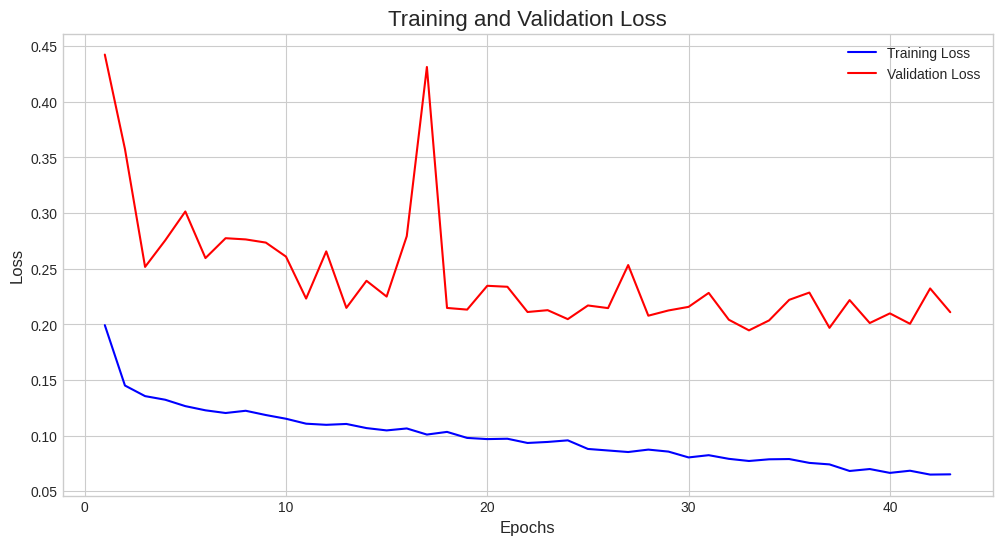

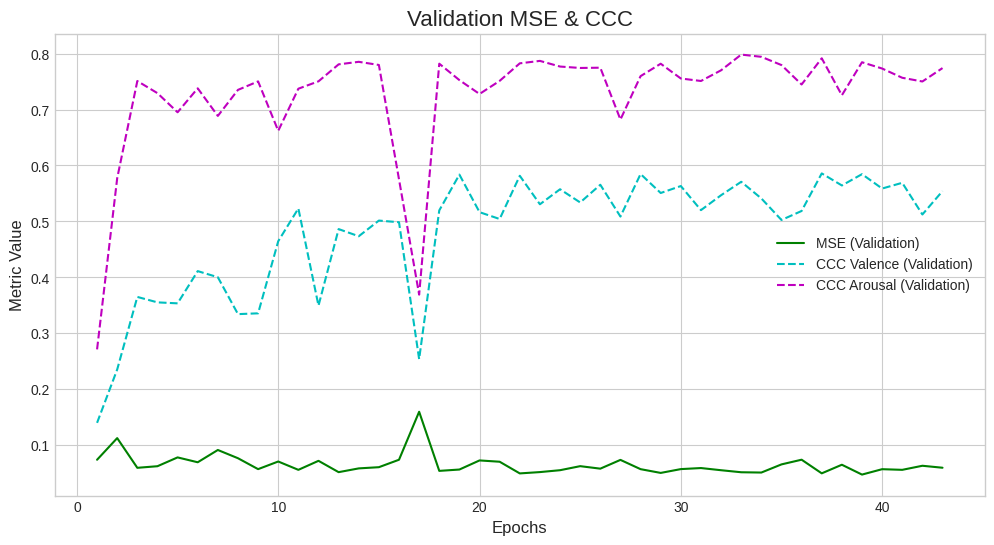

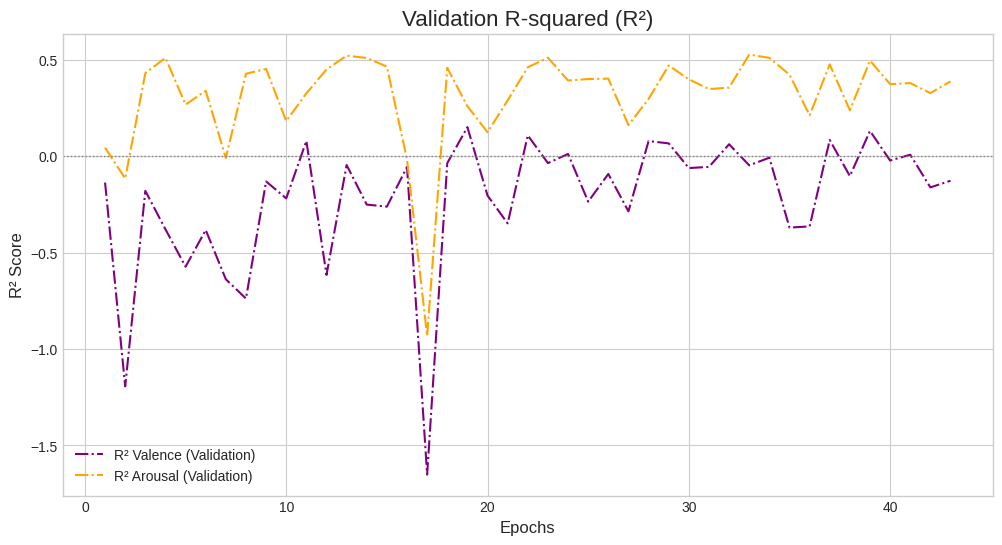

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 7) 학습 결과 시각화
# ──────────────────────────────────────────────────────────────────────────────
epochs_range = range(1, len(history['train_loss']) + 1)

# --- 1. Train/Val Loss Chart ---
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs_range, history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 2. MSE / CCC(A/V) Chart ---
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, history['mse'], 'g-', label='MSE (Validation)')
plt.plot(epochs_range, history['ccc_val'], 'c--', label='CCC Valence (Validation)')
plt.plot(epochs_range, history['ccc_aro'], 'm--', label='CCC Arousal (Validation)')
plt.title('Validation MSE & CCC', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Metric Value', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

# --- 3. R^2 Score Chart ---
plt.figure(figsize=(12, 6))
plt.plot(epochs_range, history['r2_val'], color='purple', linestyle='-.', label='R² Valence (Validation)')
plt.plot(epochs_range, history['r2_aro'], color='orange', linestyle='-.', label='R² Arousal (Validation)')
plt.axhline(0, color='grey', linestyle=':', linewidth=1) # R²=0 기준선
plt.title('Validation R-squared (R²)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

곡 단위 테스트 데이터 예측을 시작합니다...

== 전체 Test Set 결과 ==
  MSE: 0.1140, MAE: 0.2599
  R2 (V/A): -0.9654 / 0.1032
  CCC (V/A): 0.0585 / 0.5888


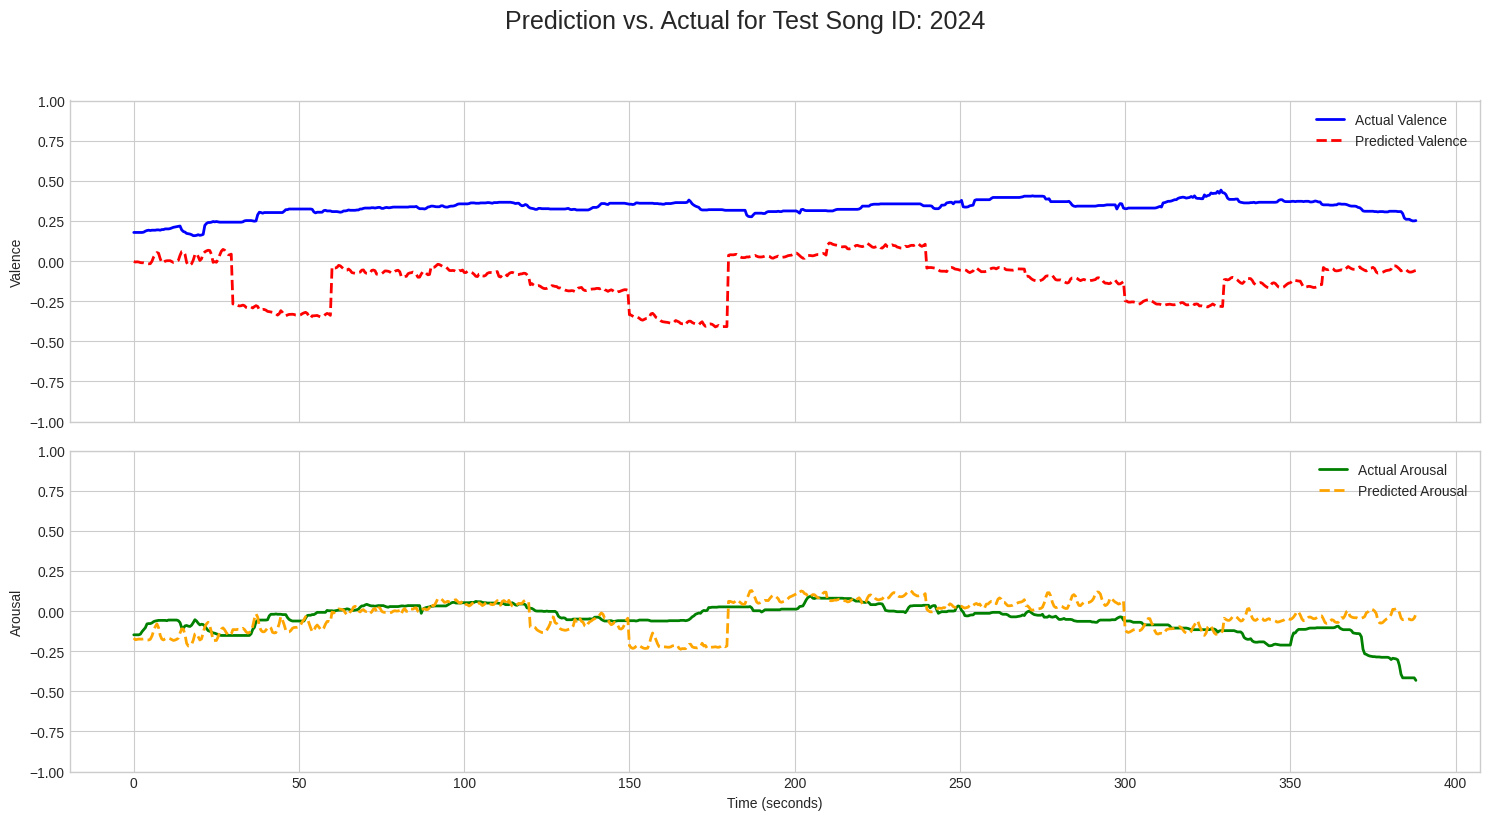


시각화 그래프를 'song_prediction_visualization.png' 파일로 저장했습니다.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import r2_score

# 이전에 정의된 concordance_correlation_coefficient 함수가 필요합니다.
def concordance_correlation_coefficient(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    true_mean = np.mean(y_true)
    pred_mean = np.mean(y_pred)
    covariance = np.mean((y_true - true_mean) * (y_pred - pred_mean))
    true_var = np.var(y_true)
    pred_var = np.var(y_pred)
    return 2 * covariance / (true_var + pred_var + (true_mean - pred_mean)**2 + 1e-8)


# ──────────────────────────────────────────────────────────────────────────────
# 1) 모델 로드 및 평가 준비
# ──────────────────────────────────────────────────────────────────────────────
model.load_state_dict(torch.load('best_model_mk4.pt'))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_song_preds = []
all_song_trues = []

print("곡 단위 테스트 데이터 예측을 시작합니다...")

# ──────────────────────────────────────────────────────────────────────────────
# 2) DataLoader 대신 test_items 리스트를 직접 순회하며 곡 단위로 예측
# ──────────────────────────────────────────────────────────────────────────────
for song_data in test_items:
    # spec_tensor의 모양: [1, 128, T_variable] (채널 차원 유지)
    spec_tensor = song_data['spec']
    ann_tensor = song_data['ann']

    T = spec_tensor.shape[-1]
    windows = []
    for start in range(0, T, 60):
        # win의 모양: [1, 128, 60] (채널 차원 유지)
        win = spec_tensor[:, :, start:start+60]

        if win.size(-1) < 60:
            pad_size = 60 - win.size(-1)
            win = torch.nn.functional.pad(win, (0, pad_size), "constant", 0)

        windows.append(win)

    if not windows:
        continue

    # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
    # [최종 수정] torch.cat 대신 torch.stack을 사용하여 올바른 4D 배치 생성
    # [1, 128, 60] 모양의 윈도우 리스트 -> [num_windows, 1, 128, 60] 모양의 4D 텐서
    # ★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★★
    batch = torch.stack(windows, dim=0)

    # stack은 새로운 차원을 생성하므로, 불필요한 차원이 있다면 squeeze()로 제거
    # 현재 `win`의 shape이 [1,128,60]이므로 stack 후 [num_win, 1, 128, 60]이 됨
    # 이 모양이 모델에 정확히 맞으므로 squeeze()는 필요 없습니다.
    batch = batch.to(device)


    with torch.no_grad():
        out = model(batch)

    preds_padded = out.cpu().numpy().reshape(-1, 2)
    preds_song = preds_padded[:T]

    all_song_preds.append(preds_song)
    all_song_trues.append(ann_tensor.cpu().numpy())


# ──────────────────────────────────────────────────────────────────────────────
# 3) 전체 테스트셋에 대한 평가 지표 계산 및 출력 (이전과 동일)
# ──────────────────────────────────────────────────────────────────────────────
if all_song_preds:
    preds_flat = np.vstack(all_song_preds)
    trues_flat = np.vstack(all_song_trues)

    mse = np.mean((preds_flat - trues_flat) ** 2)
    mae = np.mean(np.abs(preds_flat - trues_flat))
    r2_val = r2_score(trues_flat[:, 0], preds_flat[:, 0])
    r2_aro = r2_score(trues_flat[:, 1], preds_flat[:, 1])
    ccc_val = concordance_correlation_coefficient(trues_flat[:, 0], preds_flat[:, 0])
    ccc_aro = concordance_correlation_coefficient(trues_flat[:, 1], preds_flat[:, 1])

    print("\n== 전체 Test Set 결과 ==")
    print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}")
    print(f"  R2 (V/A): {r2_val:.4f} / {r2_aro:.4f}")
    print(f"  CCC (V/A): {ccc_val:.4f} / {ccc_aro:.4f}")
else:
    print("예측 결과가 없습니다.")


# ──────────────────────────────────────────────────────────────────────────────
# 4) 테스트셋의 첫 번째 곡에 대한 결과 시각화 (이전과 동일)
# ──────────────────────────────────────────────────────────────────────────────

songidid = 23
if all_song_preds:
    preds_to_plot = all_song_preds[songidid]
    trues_to_plot = all_song_trues[songidid]
    time_axis = np.arange(len(preds_to_plot)) * 0.5

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

    song_id_to_plot = test_items[songidid]['song_id']
    fig.suptitle(f'Prediction vs. Actual for Test Song ID: {song_id_to_plot}', fontsize=18, y=1.02)

    ax1.plot(time_axis, trues_to_plot[:, 0], label='Actual Valence', color='blue', linewidth=2)
    ax1.plot(time_axis, preds_to_plot[:, 0], label='Predicted Valence', color='red', linestyle='--', linewidth=2)
    ax1.set_ylabel('Valence')
    ax1.legend()
    ax1.set_ylim(-1, 1)

    ax2.plot(time_axis, trues_to_plot[:, 1], label='Actual Arousal', color='green', linewidth=2)
    ax2.plot(time_axis, preds_to_plot[:, 1], label='Predicted Arousal', color='orange', linestyle='--', linewidth=2)
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Arousal')
    ax2.legend()
    ax2.set_ylim(-1, 1)

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.savefig('song_prediction_visualization.png')
    plt.show()

    print(f"\n시각화 그래프를 'song_prediction_visualization.png' 파일로 저장했습니다.")

## Mk5 모델 키우기

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) 모델 정의 V2 (CNN & Transformer 강화 버전)
# ──────────────────────────────────────────────────────────────────────────────
class CNNFeatureExtractorV2(nn.Module):
    def __init__(self, dropout_p=0.4): # 드롭아웃 비율 상향 조정
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d((2, 1)), nn.Dropout(dropout_p),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d((2, 1)), nn.Dropout(dropout_p),

            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d((2, 1)), nn.Dropout(dropout_p),

            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d((2, 1)), nn.Dropout(dropout_p)
        )
    def forward(self, x):
        x = self.cnn(x)
        B, C, H, W = x.shape
        x = x.view(B, C * H, W)
        x = x.permute(0, 2, 1)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2] = torch.sin(pos*div)
        pe[:,1::2] = torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        return x + self.pe[:,:x.size(1),:]

class EmotionModelV2(nn.Module):
    def __init__(self, cnn, d_model=2048, nhead=16, num_layers=6, dim_feedforward=4096, dropout=0.2):
        super().__init__()
        self.cnn = cnn
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 2)
    def forward(self, x):
        feat = self.cnn(x)
        seq  = self.pos_encoder(feat)
        seq  = self.transformer(seq)
        return torch.tanh(self.regressor(seq))

print("\n[V2 모델] 아키텍처 정의 완료.")

# ──────────────────────────────────────────────────────────────────────────────
# 5) 손실 함수 및 평가지표 함수 정의
# ──────────────────────────────────────────────────────────────────────────────
class CCCLoss(nn.Module):
    def __init__(self):
        super(CCCLoss, self).__init__()
    def forward(self, y_pred, y_true):
        y_true_v, y_pred_v = y_true[..., 0], y_pred[..., 0]
        y_true_a, y_pred_a = y_true[..., 1], y_pred[..., 1]
        ccc_v = self._ccc_metric(y_pred_v, y_true_v)
        ccc_a = self._ccc_metric(y_pred_a, y_true_a)
        return ((1 - ccc_v) + (1 - ccc_a)) / 2
    def _ccc_metric(self, y_pred, y_true):
        y_true_flat, y_pred_flat = y_true.view(-1), y_pred.view(-1)
        mean_true, mean_pred = torch.mean(y_true_flat), torch.mean(y_pred_flat)
        var_true, var_pred = torch.var(y_true_flat), torch.var(y_pred_flat)
        covariance = torch.mean((y_true_flat - mean_true) * (y_pred_flat - mean_pred))
        epsilon = 1e-8
        ccc = (2 * covariance) / (var_true + var_pred + (mean_true - mean_pred)**2 + epsilon)
        return ccc

def concordance_correlation_coefficient(y_true, y_pred):
    true_mean, pred_mean = np.mean(y_true), np.mean(y_pred)
    covariance = np.mean((y_true - true_mean) * (y_pred - pred_mean))
    true_var, pred_var = np.var(y_true), np.var(y_pred)
    return 2 * covariance / (true_var + pred_var + (true_mean - pred_mean)**2 + 1e-8)

print("손실 함수 및 평가지표 함수 정의 완료.")


# ──────────────────────────────────────────────────────────────────────────────
# 6) 모델 인스턴스 및 학습 전략 설정
# ──────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_cnn_v2 = CNNFeatureExtractorV2()
model = EmotionModelV2(base_cnn_v2).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n[V2 모델] 총 파라미터 수: {total_params:,}개")

# [수정] 하이브리드 손실 및 하이퍼파라미터 설정
mse_criterion = nn.MSELoss()
ccc_criterion = CCCLoss()
lr, weight_decay = 1e-3, 5e-5 # 학습률 감소, weight_decay 증가
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5)
early_stop_patience = 15

print("모델 인스턴스 생성 및 학습 전략 설정 완료.")


# ──────────────────────────────────────────────────────────────────────────────
# 7) 학습 및 검증 루프
# ──────────────────────────────────────────────────────────────────────────────
best_val_loss = float('inf')
early_stop_counter = 0

print("\n모델 학습을 시작합니다...")
for epoch in range(1, 101): # 에포크 수를 넉넉하게 설정
    model.train()
    train_loss = 0.0
    for spec, ann in train_loader:
        spec, ann = spec.to(device), ann.to(device)
        optimizer.zero_grad()
        out = model(spec)
        loss_mse = mse_criterion(out, ann)
        loss_ccc = ccc_criterion(out, ann)
        loss = 0.5 * loss_mse + 0.5 * loss_ccc # 하이브리드 손실
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * spec.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for spec, ann in val_loader:
            spec, ann = spec.to(device), ann.to(device)
            out = model(spec)
            loss_mse = mse_criterion(out, ann)
            loss_ccc = ccc_criterion(out, ann)
            val_loss_step = 0.5 * loss_mse + 0.5 * loss_ccc
            val_loss += val_loss_step.item() * spec.size(0)
            all_preds.append(out.cpu().numpy().reshape(-1, 2))
            all_trues.append(ann.cpu().numpy().reshape(-1, 2))
    val_loss /= len(val_loader.dataset)

    preds = np.vstack(all_preds)
    trues = np.vstack(all_trues)
    mse, mae = np.mean((preds - trues)**2), np.mean(np.abs(preds - trues))
    ccc_val = concordance_correlation_coefficient(trues[:, 0], preds[:, 0])
    ccc_aro = concordance_correlation_coefficient(trues[:, 1], preds[:, 1])

    scheduler.step(val_loss)
    if val_loss < best_val_loss:
        best_val_loss, best_epoch = val_loss, epoch
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model_v2.pt')
        print(f"[{epoch:02d}] Val loss improved to {val_loss:.4f}. 모델 저장.")
    else:
        early_stop_counter += 1

    print(f"    Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Best Val Loss: {best_val_loss:.4f}")
    print(f"    Val MSE: {mse:.4f}, MAE: {mae:.4f}, CCC(V/A): {ccc_val:.4f} / {ccc_aro:.4f}")

    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch} (Best val loss: {best_val_loss:.4f} at epoch {best_epoch})")
        break

print(f"\n== 학습 완료. Best Val Loss: {best_val_loss:.4f} @ epoch {best_epoch} ==")


# ──────────────────────────────────────────────────────────────────────────────
# 8) 테스트 및 시각화
# ──────────────────────────────────────────────────────────────────────────────
print("\n테스트 데이터셋에 대한 예측 및 시각화를 시작합니다...")
model.load_state_dict(torch.load('best_model_v2.pt'))
model.eval()

all_song_preds, all_song_trues = [], []

for song_data in test_items:
    spec_tensor, ann_tensor = song_data['spec'], song_data['ann']
    T = spec_tensor.shape[-1]
    windows = []
    for start in range(0, T, 60):
        win = spec_tensor[:, :, start:start+60]
        if win.size(-1) < 60:
            pad_size = 60 - win.size(-1)
            win = torch.nn.functional.pad(win, (0, pad_size), "constant", 0)
        windows.append(win)

    if not windows: continue

    batch = torch.cat(windows, dim=0).to(device)
    with torch.no_grad():
        out = model(batch)

    preds_padded = out.cpu().numpy().reshape(-1, 2)
    preds_song = preds_padded[:T]
    all_song_preds.append(preds_song)
    all_song_trues.append(ann_tensor.cpu().numpy())

if all_song_preds:
    preds_flat, trues_flat = np.vstack(all_song_preds), np.vstack(all_song_trues)
    mse = np.mean((preds_flat - trues_flat) ** 2)
    mae = np.mean(np.abs(preds_flat - trues_flat))
    r2_val = r2_score(trues_flat[:, 0], preds_flat[:, 0])
    r2_aro = r2_score(trues_flat[:, 1], preds_flat[:, 1])
    ccc_val = concordance_correlation_coefficient(trues_flat[:, 0], preds_flat[:, 0])
    ccc_aro = concordance_correlation_coefficient(trues_flat[:, 1], preds_flat[:, 1])

    print("\n== 전체 Test Set 결과 ==")
    print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}")
    print(f"  R2 (V/A): {r2_val:.4f} / {r2_aro:.4f}")
    print(f"  CCC (V/A): {ccc_val:.4f} / {ccc_aro:.4f}")

    # 결과 시각화
    preds_to_plot = all_song_preds[0]
    trues_to_plot = all_song_trues[0]
    time_axis = np.arange(len(preds_to_plot)) * 0.5
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    song_id_to_plot = test_items[0]['song_id']
    fig.suptitle(f'Prediction vs. Actual for Test Song ID: {song_id_to_plot}', fontsize=18, y=1.02)
    ax1.plot(time_axis, trues_to_plot[:, 0], label='Actual Valence', color='blue', linewidth=2)
    ax1.plot(time_axis, preds_to_plot[:, 0], label='Predicted Valence', color='red', linestyle='--', linewidth=2)
    ax1.set_ylabel('Valence'); ax1.legend(); ax1.set_ylim(-1, 1)
    ax2.plot(time_axis, trues_to_plot[:, 1], label='Actual Arousal', color='green', linewidth=2)
    ax2.plot(time_axis, preds_to_plot[:, 1], label='Predicted Arousal', color='orange', linestyle='--', linewidth=2)
    ax2.set_xlabel('Time (seconds)'); ax2.set_ylabel('Arousal'); ax2.legend(); ax2.set_ylim(-1, 1)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


[V2 모델] 아키텍처 정의 완료.
손실 함수 및 평가지표 함수 정의 완료.

[V2 모델] 총 파라미터 수: 203,202,498개
모델 인스턴스 생성 및 학습 전략 설정 완료.

모델 학습을 시작합니다...
[01] Val loss improved to 1.0722. 모델 저장.
    Train Loss: 1.0491 | Val Loss: 1.0722 | Best Val Loss: 1.0722
    Val MSE: 1.1443, MAE: 1.0279, CCC(V/A): 0.0000 / 0.0000
    Train Loss: 1.0597 | Val Loss: 1.0722 | Best Val Loss: 1.0722
    Val MSE: 1.1443, MAE: 1.0279, CCC(V/A): 0.0000 / 0.0000
[03] Val loss improved to 1.0722. 모델 저장.
    Train Loss: 1.0597 | Val Loss: 1.0722 | Best Val Loss: 1.0722
    Val MSE: 1.1443, MAE: 1.0279, CCC(V/A): 0.0000 / 0.0000
    Train Loss: 1.0597 | Val Loss: 1.0722 | Best Val Loss: 1.0722
    Val MSE: 1.1443, MAE: 1.0279, CCC(V/A): 0.0000 / 0.0000
    Train Loss: 1.0597 | Val Loss: 1.0722 | Best Val Loss: 1.0722
    Val MSE: 1.1443, MAE: 1.0279, CCC(V/A): 0.0000 / 0.0000
    Train Loss: 1.0597 | Val Loss: 1.0722 | Best Val Loss: 1.0722
    Val MSE: 1.1443, MAE: 1.0279, CCC(V/A): 0.0000 / 0.0000
    Train Loss: 1.0597 | Val Loss: 1.0722 |

KeyboardInterrupt: 

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 8) 테스트 및 시각화
# ──────────────────────────────────────────────────────────────────────────────
print("\n테스트 데이터셋에 대한 예측 및 시각화를 시작합니다...")
model.load_state_dict(torch.load('best_model_v2.pt'))
model.eval()

all_song_preds, all_song_trues = [], []

for song_data in test_items:
    spec_tensor, ann_tensor = song_data['spec'], song_data['ann']
    T = spec_tensor.shape[-1]
    windows = []
    for start in range(0, T, 60):
        win = spec_tensor[:, :, start:start+60]
        if win.size(-1) < 60:
            pad_size = 60 - win.size(-1)
            win = torch.nn.functional.pad(win, (0, pad_size), "constant", 0)
        windows.append(win)

    if not windows: continue

    batch = torch.cat(windows, dim=0).to(device)
    with torch.no_grad():
        out = model(batch)

    preds_padded = out.cpu().numpy().reshape(-1, 2)
    preds_song = preds_padded[:T]
    all_song_preds.append(preds_song)
    all_song_trues.append(ann_tensor.cpu().numpy())

if all_song_preds:
    preds_flat, trues_flat = np.vstack(all_song_preds), np.vstack(all_song_trues)
    mse = np.mean((preds_flat - trues_flat) ** 2)
    mae = np.mean(np.abs(preds_flat - trues_flat))
    r2_val = r2_score(trues_flat[:, 0], preds_flat[:, 0])
    r2_aro = r2_score(trues_flat[:, 1], preds_flat[:, 1])
    ccc_val = concordance_correlation_coefficient(trues_flat[:, 0], preds_flat[:, 0])
    ccc_aro = concordance_correlation_coefficient(trues_flat[:, 1], preds_flat[:, 1])

    print("\n== 전체 Test Set 결과 ==")
    print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}")
    print(f"  R2 (V/A): {r2_val:.4f} / {r2_aro:.4f}")
    print(f"  CCC (V/A): {ccc_val:.4f} / {ccc_aro:.4f}")

    # 결과 시각화
    preds_to_plot = all_song_preds[0]
    trues_to_plot = all_song_trues[0]
    time_axis = np.arange(len(preds_to_plot)) * 0.5
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    song_id_to_plot = test_items[0]['song_id']
    fig.suptitle(f'Prediction vs. Actual for Test Song ID: {song_id_to_plot}', fontsize=18, y=1.02)
    ax1.plot(time_axis, trues_to_plot[:, 0], label='Actual Valence', color='blue', linewidth=2)
    ax1.plot(time_axis, preds_to_plot[:, 0], label='Predicted Valence', color='red', linestyle='--', linewidth=2)
    ax1.set_ylabel('Valence'); ax1.legend(); ax1.set_ylim(-1, 1)
    ax2.plot(time_axis, trues_to_plot[:, 1], label='Actual Arousal', color='green', linewidth=2)
    ax2.plot(time_axis, preds_to_plot[:, 1], label='Predicted Arousal', color='orange', linestyle='--', linewidth=2)
    ax2.set_xlabel('Time (seconds)'); ax2.set_ylabel('Arousal'); ax2.legend(); ax2.set_ylim(-1, 1)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

##MK6

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) 모델 정의 V3 (From Scratch)
# ──────────────────────────────────────────────────────────────────────────────
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.2):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.LeakyReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1), nn.BatchNorm2d(out_channels), nn.LeakyReLU(),
            nn.MaxPool2d((2, 1)), nn.Dropout(dropout_p)
        )
    def forward(self, x): return self.conv_block(x)

class CNNFrontEnd(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            ConvBlock(1, 64), ConvBlock(64, 128), ConvBlock(128, 256),
            ConvBlock(256, 512), ConvBlock(512, 512)
        )
    def forward(self, x):
        x = self.net(x)
        B, C, H, W = x.shape
        x = x.permute(0, 3, 1, 2).reshape(B, W, C * H)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:,:x.size(1),:]

class MER_V3(nn.Module):
    def __init__(self, cnn_out_dim=2048, d_model=768, nhead=12, num_layers=6, dim_feedforward=3072, dropout=0.2):
        super().__init__()
        self.cnn = CNNFrontEnd()
        self.input_proj = nn.Linear(cnn_out_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 2)
    def forward(self, x):
        feat = self.input_proj(self.cnn(x))
        seq = self.pos_encoder(feat)
        seq = self.transformer(seq)
        return torch.tanh(self.regressor(seq))

print("\n[V3 모델] 아키텍처 정의 완료.")


# ──────────────────────────────────────────────────────────────────────────────
# 5) 손실 함수 및 평가지표 함수 정의
# ──────────────────────────────────────────────────────────────────────────────
def concordance_correlation_coefficient(y_true, y_pred):
    true_mean, pred_mean = np.mean(y_true), np.mean(y_pred)
    covariance = np.mean((y_true - true_mean) * (y_pred - pred_mean))
    true_var, pred_var = np.var(y_true), np.var(y_pred)
    return 2 * covariance / (true_var + pred_var + (true_mean - pred_mean)**2 + 1e-8)

print("평가지표 함수 정의 완료.")




[V3 모델] 아키텍처 정의 완료.
평가지표 함수 정의 완료.


## MK7 LesNet + leackyReLU

In [ ]:
class ResNetBlock(nn.Module):
    """잔차 연결(Residual Connection)과 LeakyReLU를 적용한 CNN 블록"""
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, dropout_p=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        self.dropout = nn.Dropout(dropout_p)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.conv1(x); out = self.bn1(out); out = self.leaky_relu(out)
        out = self.dropout(out)
        out = self.conv2(out); out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.leaky_relu(out)
        return out

class CNNFrontEnd_V5(nn.Module):
    """[V5] 프레임별 특징 시퀀스 추출을 위한 ResNet-CNN"""
    def __init__(self):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # 주파수 축(Height)을 점진적으로 줄이는 ResNet 레이어들
        self.layer1 = self._make_layer(64, 2, pool=True)  # H: 128 -> 64
        self.layer2 = self._make_layer(128, 2, pool=True) # H: 64 -> 32
        self.layer3 = self._make_layer(256, 2, pool=True) # H: 32 -> 16
        self.layer4 = self._make_layer(512, 2, pool=True) # H: 16 -> 8

    def _make_layer(self, out_channels, num_blocks, pool=False):
        downsample = None
        if self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers = [ResNetBlock(self.in_channels, out_channels, downsample=downsample)]
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResNetBlock(self.in_channels, out_channels))
        if pool:
            layers.append(nn.MaxPool2d(kernel_size=(2, 1))) # 시간 축은 보존
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x) # -> [B, 512, 8, 60]

        B, C, H, W = x.shape
        x = x.permute(0, 3, 1, 2).reshape(B, W, C * H) # -> [B, 60, 4096]
        return x

class MER_V5(nn.Module):
    """[V5] 최종 모델: ResNet-CNN + Transformer (프레임별 예측)"""
    def __init__(self, cnn_out_dim=4096, d_model=768, nhead=12, num_layers=6, dim_feedforward=3072, dropout=0.2):
        super().__init__()
        self.cnn = CNNFrontEnd_V5()
        self.input_proj = nn.Linear(cnn_out_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len=60)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 2)

    def forward(self, x):
        feat = self.input_proj(self.cnn(x))
        seq = self.pos_encoder(feat)
        seq = self.transformer(seq)
        return torch.tanh(self.regressor(seq))

print("[V5 모델] 아키텍처 재설계 완료.")


[V5 모델] 아키텍처 재설계 완료.


## MK8 CNN 구조 변경

Epoch [23/101] - 4.05s/epoch
Train Loss: 0.0340 | Val Loss: 0.0888 | Best Val Loss: 0.0487
Val CCC (V/A): 0.4437 / 0.4876
Patience: 12/12
Early stopping at epoch 23.

== 학습 완료. 총 학습 시간: 1.64분 | Best Epoch: 11 ==

학습 과정 시각화를 시작합니다...


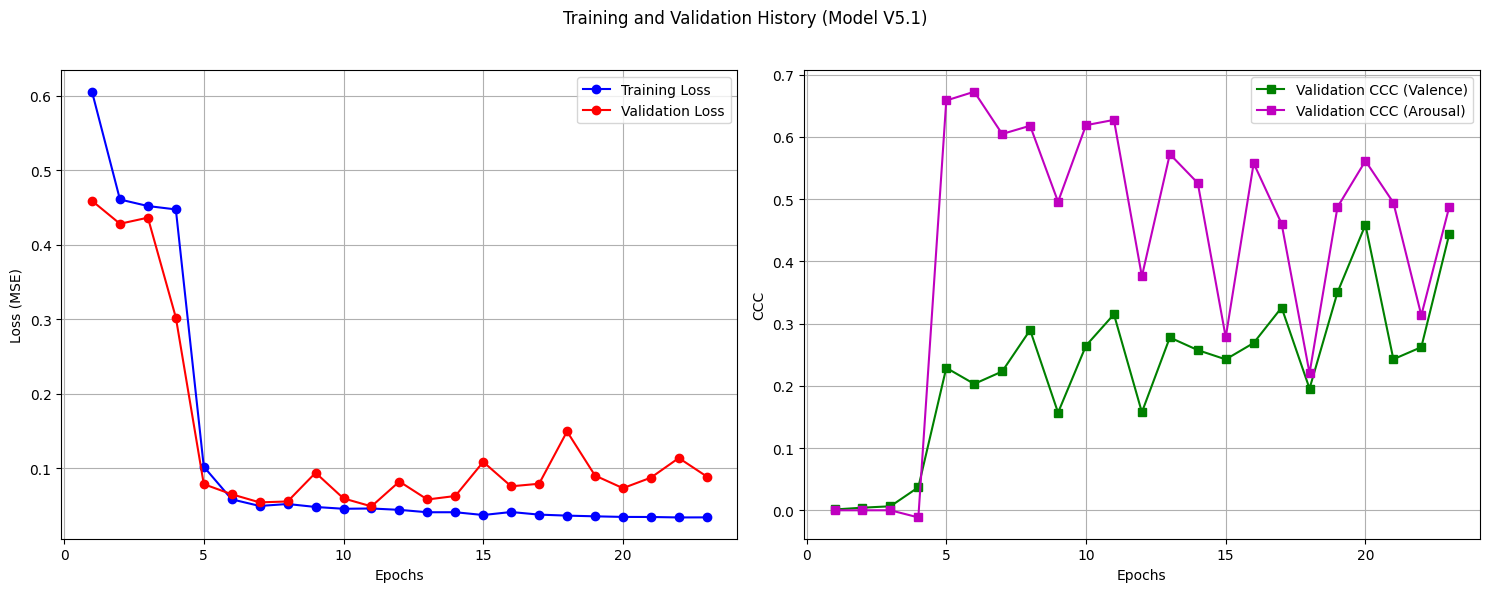

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 4) 모델 정의 V5.1 (비대칭 커널 ResNet-CNN + Transformer)
# ──────────────────────────────────────────────────────────────────────────────
class AsymmetricConvBlock(nn.Module):
    """주파수 축과 시간 축을 분리하여 처리하는 비대칭 커널 블록"""
    def __init__(self, channels, dropout_p=0.3):
        super().__init__()
        self.freq_conv = nn.Conv2d(channels, channels, kernel_size=(7, 1), padding=(3, 0), groups=channels, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.time_conv = nn.Conv2d(channels, channels, kernel_size=(1, 7), padding=(0, 3), groups=channels, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)
        self.pointwise_conv = nn.Conv2d(channels, channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(channels)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.05, inplace=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x):
        identity = x
        out = self.leaky_relu(self.bn1(self.freq_conv(x)))
        out = self.leaky_relu(self.bn2(self.time_conv(out)))
        out = self.leaky_relu(self.bn3(self.pointwise_conv(out)))
        out = self.dropout(out)
        return out + identity

class CNNFrontEnd_V5_1(nn.Module):
    """프레임별 특징 시퀀스 추출을 위한 비대칭 ResNet-CNN"""
    def __init__(self):
        super().__init__()
        self.initial_conv = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.initial_bn = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 128)
        self.layer2 = self._make_layer(128, 128)
        self.layer3 = self._make_layer(128, 128)
        self.layer4 = self._make_layer(128, 512)

    def _make_layer(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            AsymmetricConvBlock(out_channels),
            nn.MaxPool2d(kernel_size=(2, 1))
        )
    def forward(self, x):
        x = F.leaky_relu(self.initial_bn(self.initial_conv(x)), negative_slope=0.01)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        B, C, H, W = x.shape
        x = x.permute(0, 3, 1, 2).reshape(B, W, C * H)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 60):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float() * (-math.log(10000.0)/d_model))
        pe[:,0::2], pe[:,1::2] = torch.sin(pos*div), torch.cos(pos*div)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x): return x + self.pe[:,:x.size(1),:]

class MER_V5_1(nn.Module):
    """최종 모델: 비대칭 ResNet-CNN + Transformer (프레임별 예측)"""
    def __init__(self, cnn_out_dim=4096, d_model=768, nhead=12, num_layers=6, dim_feedforward=3072, dropout=0.4):
        super().__init__()
        self.cnn = CNNFrontEnd_V5_1()
        self.input_proj = nn.Linear(cnn_out_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout, activation='gelu', batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Linear(d_model, 2)

    def forward(self, x):
        feat = self.input_proj(self.cnn(x))
        seq = self.pos_encoder(feat)
        seq = self.transformer(seq)
        return torch.tanh(self.regressor(seq))

print("\n[V5.1 모델] 아키텍처 정의 완료.")


# ──────────────────────────────────────────────────────────────────────────────
# 5) 평가지표 함수 정의
# ──────────────────────────────────────────────────────────────────────────────
def concordance_correlation_coefficient(y_true, y_pred):
    true_mean, pred_mean = np.mean(y_true), np.mean(y_pred)
    covariance = np.mean((y_true - true_mean) * (y_pred - pred_mean))
    true_var, pred_var = np.var(y_true), np.var(y_pred)
    return 2 * covariance / (true_var + pred_var + (true_mean - pred_mean)**2 + 1e-8)

print("평가지표 함수 정의 완료.")


# ──────────────────────────────────────────────────────────────────────────────
# 6) 모델 인스턴스 및 학습 전략 설정
# ──────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MER_V5_1().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"\n[V5.1 모델] 총 파라미터 수: {total_params:,}개")

lr, weight_decay = 1e-4, 1e-5
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stop_patience = 12
print("모델 인스턴스 생성 및 학습 전략 설정 완료.")


# ──────────────────────────────────────────────────────────────────────────────
# 7) 학습 및 검증 루프 (프레임별 예측)
# ──────────────────────────────────────────────────────────────────────────────
best_val_loss = float('inf')
early_stop_counter = 0
history = {'train_loss': [], 'val_loss': [], 'val_ccc_v': [], 'val_ccc_a': []}

print("\n[V5.1 모델] 학습을 시작합니다...")
start_time = time.time()
for epoch in range(1, 101):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    for spec, ann in train_loader:
        spec, ann = spec.to(device), ann.to(device)
        optimizer.zero_grad()
        out = model(spec)
        loss = criterion(out, ann)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * spec.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for spec, ann in val_loader:
            spec, ann = spec.to(device), ann.to(device)
            out = model(spec)
            val_loss += criterion(out, ann).item() * spec.size(0)
            all_preds.append(out.cpu().numpy())
            all_trues.append(ann.cpu().numpy())
    val_loss /= len(val_loader.dataset)

    preds = np.vstack(all_preds).reshape(-1, 2)
    trues = np.vstack(all_trues).reshape(-1, 2)
    ccc_val = concordance_correlation_coefficient(trues[:, 0], preds[:, 0])
    ccc_aro = concordance_correlation_coefficient(trues[:, 1], preds[:, 1])

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_ccc_v'].append(ccc_val)
    history['val_ccc_a'].append(ccc_aro)

    clear_output(wait=True)
    epoch_duration = time.time() - epoch_start_time

    print(f"Epoch [{epoch:02d}/{101}] - {epoch_duration:.2f}s/epoch")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Best Val Loss: {best_val_loss:.4f}")
    print(f"Val CCC (V/A): {ccc_val:.4f} / {ccc_aro:.4f}")

    if val_loss < best_val_loss:
        best_val_loss, best_epoch = val_loss, epoch
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model_v5_1.pt')
        print("★ Validation loss improved. Model saved.")
    else:
        early_stop_counter += 1
        print(f"Patience: {early_stop_counter}/{early_stop_patience}")

    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch}.")
        break

total_duration = time.time() - start_time
print(f"\n== 학습 완료. 총 학습 시간: {total_duration/60:.2f}분 | Best Epoch: {best_epoch} ==")


# ──────────────────────────────────────────────────────────────────────────────
# 8) 학습 과정 시각화
# ──────────────────────────────────────────────────────────────────────────────
print("\n학습 과정 시각화를 시작합니다...")
epochs_range = range(1, len(history['train_loss']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Training and Validation History (Model V5.1)')
ax1.plot(epochs_range, history['train_loss'], 'bo-', label='Training Loss')
ax1.plot(epochs_range, history['val_loss'], 'ro-', label='Validation Loss')
ax1.set_xlabel('Epochs'); ax1.set_ylabel('Loss (MSE)'); ax1.legend(); ax1.grid(True)
ax2.plot(epochs_range, history['val_ccc_v'], 'gs-', label='Validation CCC (Valence)')
ax2.plot(epochs_range, history['val_ccc_a'], 'ms-', label='Validation CCC (Arousal)')
ax2.set_xlabel('Epochs'); ax2.set_ylabel('CCC'); ax2.legend(); ax2.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [ ]:
import time # 학습 시간 측정을 위해 추가

from IPython.display import display, clear_output

# ──────────────────────────────────────────────────────────────────────────────
# 6) 모델 인스턴스 및 학습 전략 설정 (MSELoss 단독 사용)
# ──────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MER_V3().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"\n[V3 모델] 총 파라미터 수: {total_params:,}개")

lr, weight_decay = 1e-4, 1e-6
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)
criterion = nn.MSELoss()
early_stop_patience = 12
print("모델 인스턴스 생성 및 학습 전략 설정 완료.")


[V4 모델] 총 파라미터 수: 53,512,130개
모델 인스턴스 생성 및 학습 전략 설정 완료.


In [ ]:
import time # 학습 시간 측정을 위해 추가

from IPython.display import display, clear_output

# ──────────────────────────────────────────────────────────────────────────────
# 6) 모델 인스턴스 및 학습 전략 설정 (MSELoss 단독 사용)
# ──────────────────────────────────────────────────────────────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MER_V5().to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"\n[MK7 모델] 총 파라미터 수: {total_params:,}개")

lr, weight_decay = 1e-4, 1e-6
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=7, factor=0.5)
criterion = nn.MSELoss()
early_stop_patience = 12
print("모델 인스턴스 생성 및 학습 전략 설정 완료.")


[MK7 모델] 총 파라미터 수: 56,842,946개
모델 인스턴스 생성 및 학습 전략 설정 완료.


Epoch [05/100] - 4.06s/epoch
Train Loss: 0.0396 | Val Loss: 0.0856 | Best Val Loss: 0.0441
Val CCC (V/A): 0.2925 / 0.5021
Patience: 4/12


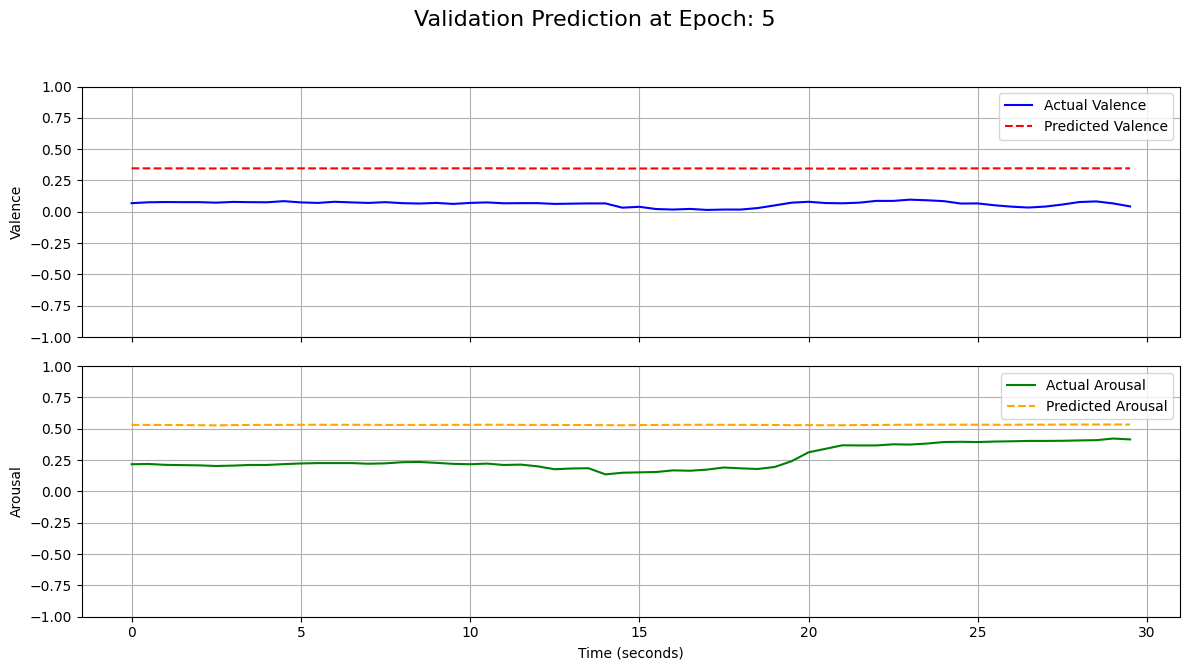

KeyboardInterrupt: 

In [ ]:
# 시각화를 위해 검증 데이터셋에서 하나의 샘플을 미리 고정해 둡니다.
vis_sample = val_items[0]
vis_spec_tensor = vis_sample['spec']
vis_ann_tensor = vis_sample['ann']

def visualize_epoch_prediction(model, epoch, spec_tensor, ann_tensor, device):
    """매 에포크의 검증 예측 결과를 시각화하는 함수"""
    model.eval() # 모델을 평가 모드로 설정

    T = spec_tensor.shape[-1]
    windows = []
    for start in range(0, T, 60):
        win = spec_tensor[:, :, start:start+60]
        if win.size(-1) < 60:
            win = F.pad(win, (0, 60 - win.size(-1)), "constant", 0)
        windows.append(win)

    if not windows: return

    # [중요] stack을 사용하여 올바른 4D 배치 생성
    batch = torch.stack([w.squeeze(0) for w in windows], dim=0)
    batch = batch.unsqueeze(1).to(device)

    with torch.no_grad():
        out = model(batch)

    preds_padded = out.cpu().numpy().reshape(-1, 2)
    preds_song = preds_padded[:T]
    trues_song = ann_tensor.cpu().numpy()

    # 시각화
    time_axis = np.arange(len(preds_song)) * 0.5
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

    fig.suptitle(f'Validation Prediction at Epoch: {epoch}', fontsize=16)
    ax1.plot(time_axis, trues_song[:, 0], label='Actual Valence', color='blue')
    ax1.plot(time_axis, preds_song[:, 0], label='Predicted Valence', color='red', linestyle='--')
    ax1.set_ylabel('Valence'); ax1.legend(); ax1.set_ylim(-1, 1); ax1.grid(True)

    ax2.plot(time_axis, trues_song[:, 1], label='Actual Arousal', color='green')
    ax2.plot(time_axis, preds_song[:, 1], label='Predicted Arousal', color='orange', linestyle='--')
    ax2.set_xlabel('Time (seconds)'); ax2.set_ylabel('Arousal'); ax2.legend(); ax2.set_ylim(-1, 1); ax2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



# ──────────────────────────────────────────────────────────────────────────────
# 7) 학습 및 검증 루프 (학습 히스토리 기록 추가)
# ──────────────────────────────────────────────────────────────────────────────
best_val_loss = float('inf')
early_stop_counter = 0
history = {'train_loss': [], 'val_loss': [], 'val_ccc_v': [], 'val_ccc_a': []}

print("\n[V4 모델] 학습을 시작합니다...")
start_time = time.time()
for epoch in range(1, 101):
    epoch_start_time = time.time()
    model.train()
    train_loss = 0.0
    for spec, ann in train_loader:
        spec, ann = spec.to(device), ann.to(device)
        optimizer.zero_grad(); out = model(spec); loss = criterion(out, ann)
        loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0); optimizer.step()
        train_loss += loss.item() * spec.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    all_preds, all_trues = [], []
    with torch.no_grad():
        for spec, ann in val_loader:
            spec, ann = spec.to(device), ann.to(device)
            out = model(spec)
            val_loss += criterion(out, ann).item() * spec.size(0)
            all_preds.append(out.cpu().numpy()); all_trues.append(ann.cpu().numpy())
    val_loss /= len(val_loader.dataset)

    preds, trues = np.vstack(all_preds).reshape(-1, 2), np.vstack(all_trues).reshape(-1, 2)
    ccc_val = concordance_correlation_coefficient(trues[:, 0], preds[:, 0])
    ccc_aro = concordance_correlation_coefficient(trues[:, 1], preds[:, 1])

    # [추가] 학습 히스토리 기록
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_ccc_v'].append(ccc_val)
    history['val_ccc_a'].append(ccc_aro)


    # --- 출력 및 모델 저장 ---
    # clear_output(wait=True) # 이전 출력을 지우고 새로 업데이트
    epoch_duration = time.time() - epoch_start_time

    print(f"Epoch [{epoch:02d}/{100}] - {epoch_duration:.2f}s/epoch")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Best Val Loss: {best_val_loss:.4f}")
    print(f"Val CCC (V/A): {ccc_val:.4f} / {ccc_aro:.4f}")

    if val_loss < best_val_loss:
        best_val_loss, best_epoch = val_loss, epoch
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model_v3.pt')
        print("★ Validation loss improved. Model saved.")
    else:
        early_stop_counter += 1
        print(f"Patience: {early_stop_counter}/{early_stop_patience}")

    # [추가] 매 에포크마다 검증 예측 시각화 함수 호출
    visualize_epoch_prediction(model, epoch, vis_spec_tensor, vis_ann_tensor, device)

    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch}.")
        break

total_duration = time.time() - start_time
print(f"\n== 학습 완료. 총 학습 시간: {total_duration/60:.2f}분 ==")




학습 과정 시각화를 시작합니다...


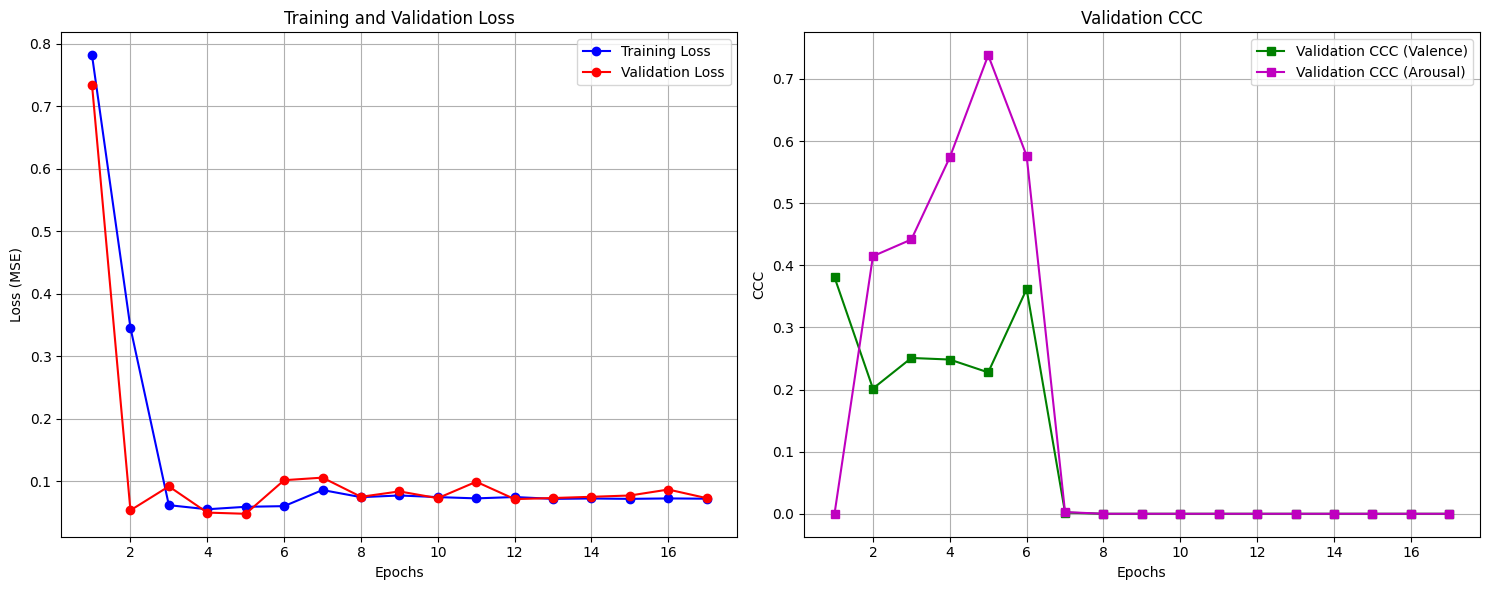

In [ ]:

# ──────────────────────────────────────────────────────────────────────────────
# 8) [추가] 학습 과정 시각화
# ──────────────────────────────────────────────────────────────────────────────
print("\n학습 과정 시각화를 시작합니다...")
epochs_range = range(1, len(history['train_loss']) + 1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 손실 그래프
ax1.plot(epochs_range, history['train_loss'], 'bo-', label='Training Loss')
ax1.plot(epochs_range, history['val_loss'], 'ro-', label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss (MSE)')
ax1.legend()
ax1.grid(True)

# CCC 그래프
ax2.plot(epochs_range, history['val_ccc_v'], 'gs-', label='Validation CCC (Valence)')
ax2.plot(epochs_range, history['val_ccc_a'], 'ms-', label='Validation CCC (Arousal)')
ax2.set_title('Validation CCC')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('CCC')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
import matplotlib.pyplot as plt


테스트 데이터셋에 대한 예측 및 시각화를 시작합니다...

== 모델 전체 Test Set 결과 ==
  MSE: 0.0943, MAE: 0.2464
  R2 (V/A): -0.3439 / -0.0681
  CCC (V/A): 0.1477 / 0.3929


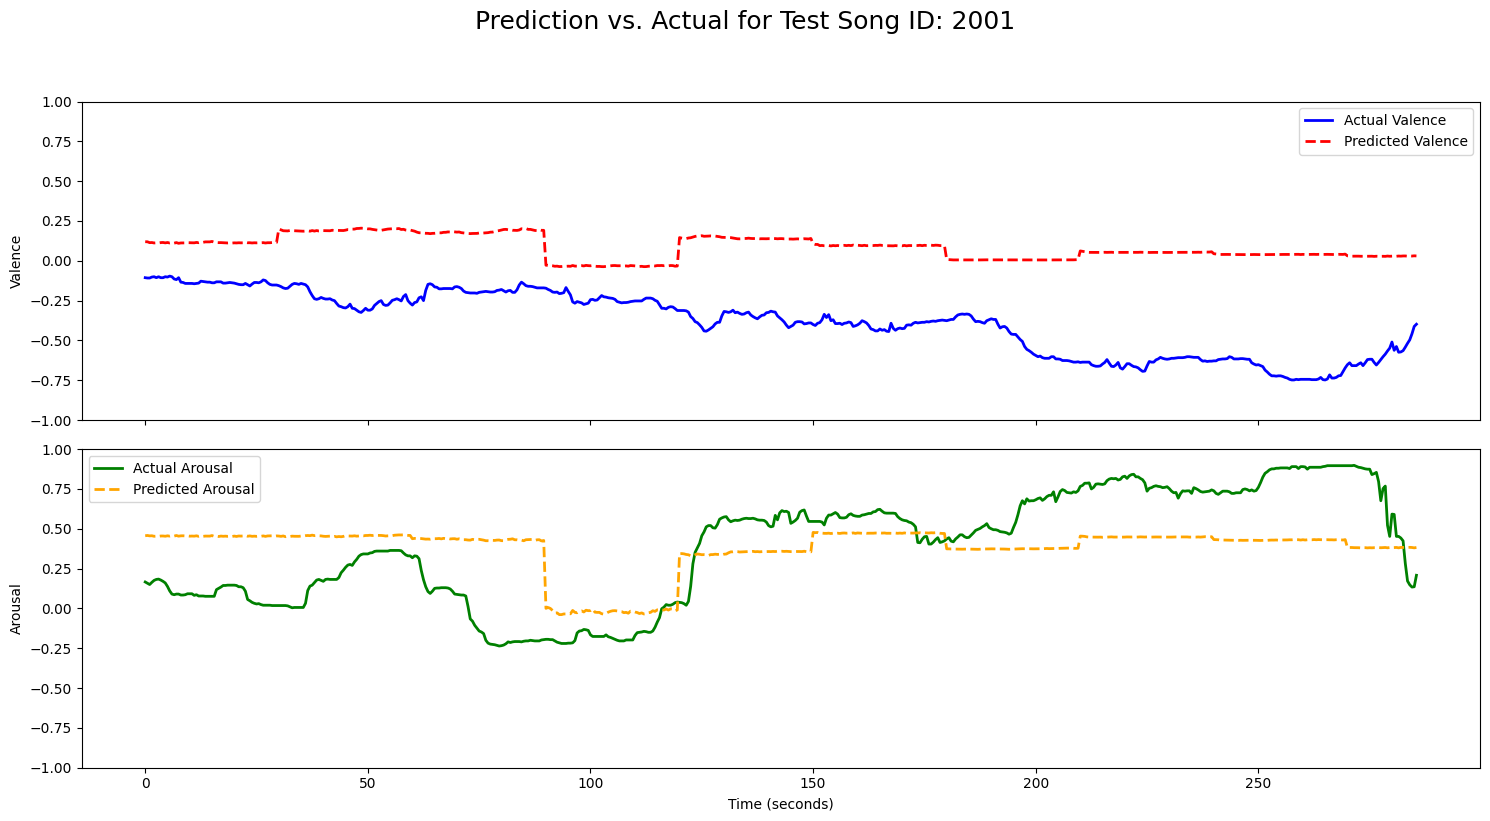

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 9) [수정] 테스트 및 결과 시각화
# ──────────────────────────────────────────────────────────────────────────────
print("\n테스트 데이터셋에 대한 예측 및 시각화를 시작합니다...")
model.load_state_dict(torch.load('best_model_v3.pt'))
model.eval()

all_song_preds, all_song_trues = [], []

for song_data in test_items:
    spec_tensor, ann_tensor = song_data['spec'], song_data['ann']
    T = spec_tensor.shape[-1]
    windows = []
    for start in range(0, T, 60):
        win = spec_tensor[:, :, start:start+60]
        if win.size(-1) < 60:
            win = F.pad(win, (0, 60 - win.size(-1)), "constant", 0)
        windows.append(win)

    if not windows: continue

    # [중요] torch.stack을 사용하여 올바른 4D 배치 생성
    batch = torch.stack([w.squeeze(0) for w in windows], dim=0)
    batch = batch.unsqueeze(1).to(device) # -> [num_windows, 1, 128, 60]

    with torch.no_grad():
        out = model(batch)

    preds_padded = out.cpu().numpy().reshape(-1, 2)
    preds_song = preds_padded[:T]
    all_song_preds.append(preds_song)
    all_song_trues.append(ann_tensor.cpu().numpy())

if all_song_preds:
    preds_flat, trues_flat = np.vstack(all_song_preds), np.vstack(all_song_trues)
    mse, mae = np.mean((preds_flat - trues_flat) ** 2), np.mean(np.abs(preds_flat - trues_flat))
    r2_val = r2_score(trues_flat[:, 0], preds_flat[:, 0])
    r2_aro = r2_score(trues_flat[:, 1], preds_flat[:, 1])
    ccc_val = concordance_correlation_coefficient(trues_flat[:, 0], preds_flat[:, 0])
    ccc_aro = concordance_correlation_coefficient(trues_flat[:, 1], preds_flat[:, 1])

    print("\n== 모델 전체 Test Set 결과 ==")
    print(f"  MSE: {mse:.4f}, MAE: {mae:.4f}")
    print(f"  R2 (V/A): {r2_val:.4f} / {r2_aro:.4f}")
    print(f"  CCC (V/A): {ccc_val:.4f} / {ccc_aro:.4f}")

    # 테스트 곡 결과 시각화
    preds_to_plot, trues_to_plot = all_song_preds[0], all_song_trues[0]
    time_axis = np.arange(len(preds_to_plot)) * 0.5
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    song_id_to_plot = test_items[0]['song_id']
    fig.suptitle(f'Prediction vs. Actual for Test Song ID: {song_id_to_plot}', fontsize=18, y=1.02)
    ax1.plot(time_axis, trues_to_plot[:, 0], label='Actual Valence', color='blue', linewidth=2)
    ax1.plot(time_axis, preds_to_plot[:, 0], label='Predicted Valence', color='red', linestyle='--', linewidth=2)
    ax1.set_ylabel('Valence'); ax1.legend(); ax1.set_ylim(-1, 1)
    ax2.plot(time_axis, trues_to_plot[:, 1], label='Actual Arousal', color='green', linewidth=2)
    ax2.plot(time_axis, preds_to_plot[:, 1], label='Predicted Arousal', color='orange', linestyle='--', linewidth=2)
    ax2.set_xlabel('Time (seconds)'); ax2.set_ylabel('Arousal'); ax2.legend(); ax2.set_ylim(-1, 1)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()